In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

In [2]:
# Standard library imports
from pathlib import Path  # File system path operations and management
from collections.abc import Callable  # Type hinting for callable objects/functions
from typing import Literal  # Literal type hints for restricted variable values

# Data manipulation and numerical computing
import numpy as np  # Numerical computations and array operations
import pandas as pd  # Data manipulation and analysis with DataFrames

# Data visualization
import matplotlib.pyplot as plt  # Creating static, interactive visualizations
import seaborn as sns  # Statistical data visualization built on Matplotlib

# Scikit-learn imports
from sklearn.model_selection import train_test_split  # Split dataset into training and testing subsets
from sklearn.metrics import (  # Model evaluation metrics
    accuracy_score,           # Classification accuracy
    classification_report,    # Detailed classification metrics
)
from sklearn.preprocessing import StandardScaler  # Feature standardization (zero mean, unit variance)

# PyTorch imports
import torch  # Main PyTorch package
import torch.nn as nn  # Neural network modules and layers
from torch.utils.data import DataLoader, Dataset  # Data loading and custom datasets
from torchsummary import summary  # Model architecture summary
from torchvision import datasets  # Pre-built vision datasets
from torchvision.transforms import v2  # Image transformations and augmentations
from torch.utils.data import random_split # randomized datasplit
# Custom utility functions from local module
from utils.helper import (
    fn_plot_torch_hist,       # Plot training history for PyTorch models
    fn_plot_confusion_matrix, # Custom confusion matrix visualization
    fn_plot_label             # Label plotting utility
)

2025-11-07 11:18:54.607195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
###----------------------
### The "Let's Get This Party Started" Zone
###----------------------

# Where the magic begins - our data's home address
inpDir = Path('..') / '..' / 'input'    # Going two levels up, looking for data
outDir = Path('..') / 'output'           # Where our brilliant results will live
modelDir = Path('..') / 'models'         # Hotel for our AI brainchildren
subDir = 'flower_photos'                 # Because even AI needs to stop and smell the roses

# What to call our masterpiece when it grows up
modelFileName = 'best_weights.pth'       # The chosen one

# The number that keeps our randomness in check (like a bouncer for chaos)
RANDOM_STATE = 24                        # The answer to life, universe, and everything (minus 17)
torch.manual_seed(RANDOM_STATE)          # Making sure our AI doesn't get creative with randomness

###-------------------------------------
### Training Regiment (No Pain, No Gain)
###-------------------------------------

EPOCHS = 81                              # Because 80 was too mainstream, 82 too eager
BATCH_SIZE = 16                          # Sweet sixteen - not too big, not too small
IMG_HEIGHT = 190                         # Pixels tall (the model's preferred height)
IMG_WIDTH = 190                          # Pixels wide (it likes squares, apparently)
ALPHA = 0.001                            # Learning rate: slow and steady wins the race
TRAIN_SIZE = 183 * BATCH_SIZE            # Bar napkin math that somehow works
LR_FACTOR = 0.1                          # Learning rate shrink ray factor
LR_PATIENCE = 5                          # How many bad report cards before we lower expectations

###--------------------------------
### Making Things Pretty Department
###--------------------------------

# Dressing up our plots for their big debut
params = {
    'legend.fontsize': 'large',          # Big words for important people
    'figure.figsize': (15, 10),          # Go big or go home
    'axes.labelsize': 'medium',           # Labels you can actually read
    'axes.titlesize': 'medium',           # Titles that demand attention
    'xtick.labelsize': 'medium',          # X-axis numbers that aren't shy
    'ytick.labelsize': 'medium'           # Y-axis numbers joining the party
}

CMAP = plt.cm.coolwarm                   # The color scheme of sophisticated AI

plt.rcParams.update(params)              # Applying the makeover

plt.style.use('seaborn-v0_8-darkgrid')   # Because even data deserves to look fabulous

## Basic Hygiene

In [4]:
# Create main output directory if it doesn't exist
# parents=True: Create parent directories if needed
# exist_ok=True: Ok it it exists, do not crib
outDir.mkdir(parents=True, exist_ok=True)
modelSubDir = modelDir / subDir
modelSubDir.mkdir(parents=True, exist_ok=True)

#### All about CUDA

In [5]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.8
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


### Helper Function for images

In [7]:
# Display an image tensor with optional denormalization and clean formatting.
def fn_imshow(image:torch.Tensor, 
              title: str =None, 
              normalize: bool=True, 
              ax =None):
    '''
    Args:
    
        image : torch.Tensor
            Input image tensor in (C, H, W) format
        title : str, optional
            Title for the image plot
        normalize : bool, default=True
            Whether to denormalize using ImageNet statistics
        ax : matplotlib.axes.Axes, optional
            Existing axes to plot on. If None, creates new figure
        
    Returns: matplotlib.axes.Axes
        The axes object with the plotted image
    '''

    # Create a new figure if no axes provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Convert tensor to numpy array and change dimension order from (C, H, W) to (H, W, C)
    image = image.numpy().transpose((1, 2, 0))
    
    # Denormalize if image was normalized during preprocessing
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
        std = np.array([0.229, 0.224, 0.225])   # ImageNet standard deviation
        image = image * std + mean               # Reverse normalization
        image = np.clip(image, 0, 1)             # Ensure pixel values are valid
    
    # Display the image
    ax.imshow(image, cmap=plt.cm.binary)
    
    # Remove all spines (borders)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Remove tick marks and labels
    ax.tick_params(axis='both', length=0)        # Hide tick marks
    ax.set_xticklabels('')                       # Remove x-axis labels
    ax.set_yticklabels('')                       # Remove y-axis labels
    
    # Remove grid
    ax.grid(visible=False)
    
    # Set title if provided
    ax.set_title(title)
    
    return ax

In [8]:
# Apply transforms using a wrapper class
class ApplyTransform:
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

In [9]:
###---------------
### Transformation
###---------------

# Training transform with augmentation
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_HEIGHT, IMG_WIDTH)),
    v2.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
    # v2.RandAugment(),  # Automated augmentation policy
    # Data augmentation - more appropriate for fashion items
    # v2.RandomHorizontalFlip(p=0.5),      # Common for clothing
    # v2.RandomVerticalFlip(p=0.3),        # Less common but possible for some items
    # v2.RandomRotation(degrees=15),       # Items can be rotated, but not recommended for 28 x 28 images 
    # v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations,  but not recommended for 28 x 28 images 
    # v2.ColorJitter(brightness=0.2, contrast=0.2),  # Lighting variations,  but not recommended for 28 x 28 images 
    v2.Normalize( mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Test transform without augmentation
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_HEIGHT, IMG_WIDTH)),
    v2.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
    v2.Normalize( mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

## Read Flowers data set

In [10]:
data_dir = inpDir/subDir

dataset = datasets.ImageFolder(data_dir, transform=None)

# Split dataset
train_size = TRAIN_SIZE
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

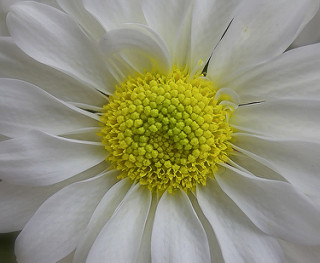

In [11]:
image, label = next(iter(dataset))
image

In [12]:
print (len(dataset), train_size, test_size)

3670 2928 742


In [13]:
# Class Names as Dict

class_names = {}
for count, name in enumerate(train_dataset.dataset.classes):
    class_names[count] = name
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [14]:
# How many Classes
numClasses = len(class_names)
numClasses

5

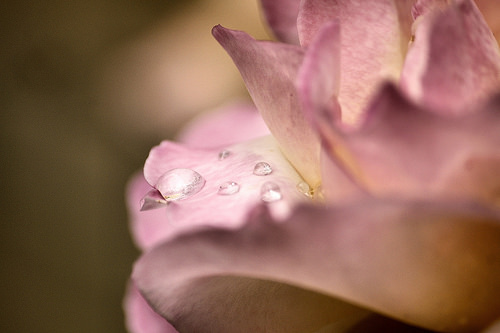

In [15]:
next(iter(train_dataset))[0]

## Data Loader

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

In [17]:
labels[i].numpy()

NameError: name 'labels' is not defined

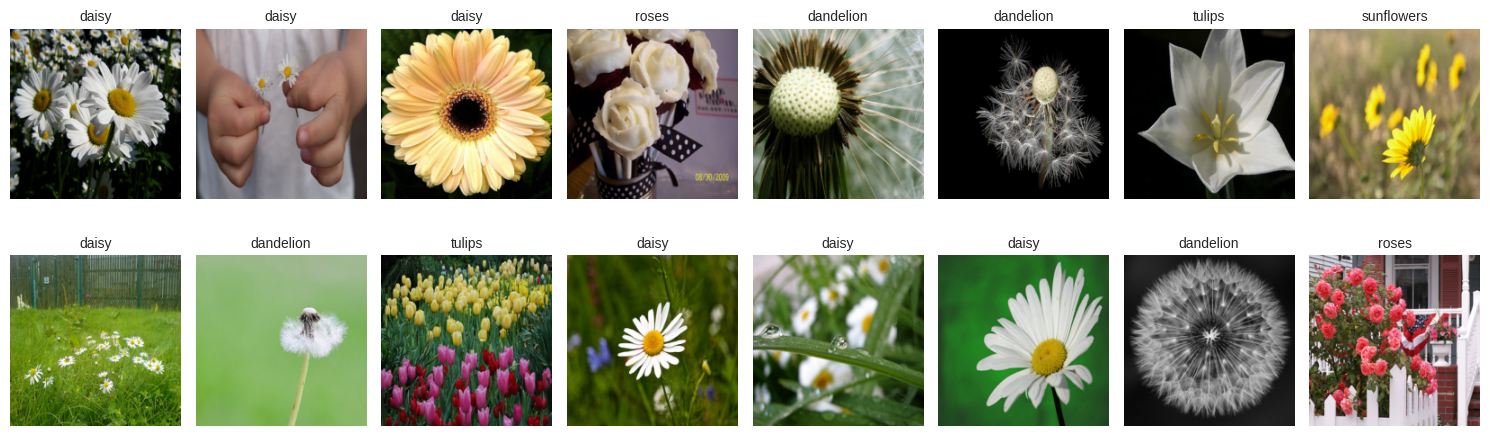

In [ ]:
images, labels =next(iter(train_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,5))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_imshow(images[i], ax=ax, title=class_names[labels[i].item()])
plt.tight_layout()

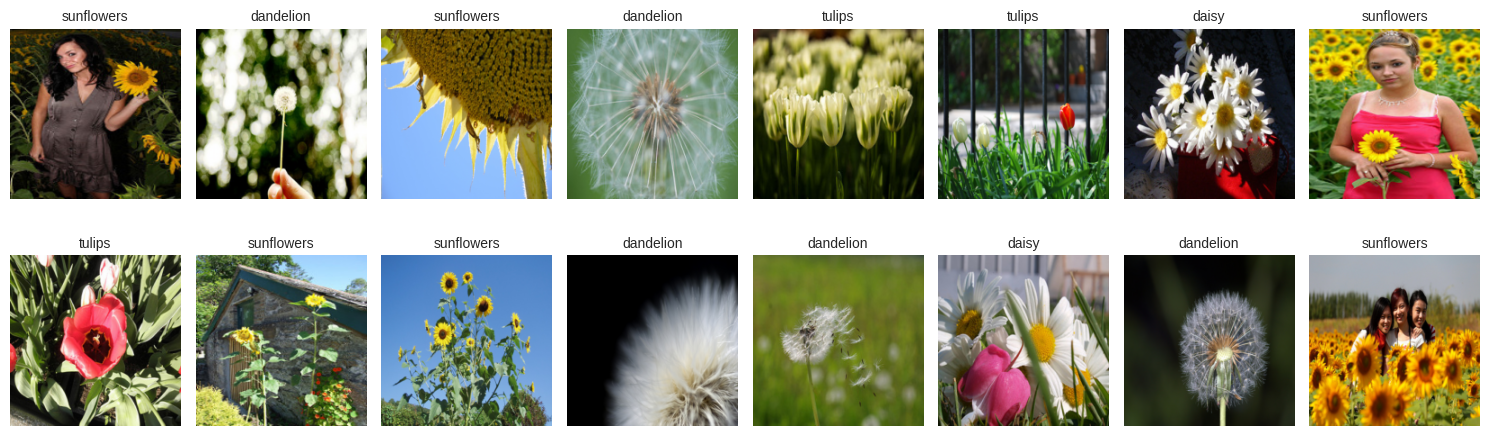

In [ ]:
images, labels =next(iter(test_dataloader))

#print (images.shape, labels.shape)

fig = plt.figure(figsize=(15,5))

for i in range (BATCH_SIZE):

    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    
    fn_imshow(images[i], ax=ax, title=class_names[labels[i].item()])
plt.tight_layout()